## Download Refcocog and instal necessary packages (CLIP, lavis)

In [ ]:
# CLIP
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

# REFCOCOG
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
!tar -xf /content/refcocog.tar.gz
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

#LAVIS
!pip install salesforce-lavis


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-x2yteoli
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-x2yteoli
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=ecc1335c4823ddd512c94db5e89884b2ddcad57ec2535f421e152509669a37b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-8b8d4g7j/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Access denied with the following error:

 	Too many users have viewed or downloaded this file 

## Import necessary packages and define models

In [ ]:
import clip
import torch
import numpy as np
import lavis
import locale
import matplotlib.pyplot as plt
from PIL import Image


locale.getpreferredencoding = lambda: 'UTF-8'

blip_caption, image_preprocess_blip_cap, _ = lavis.models.load_model_and_preprocess(
    name='blip_caption', model_type='large_coco', is_eval=True, device='cuda'
    )

blip_im_text_match, image_preprocess_im_text_match, text_preprocess_im_text_match = lavis.models.load_model_and_preprocess(
    name="blip_image_text_matching", model_type="large", is_eval=True, device='cuda'
  )

modelCLIP, preprocessCLIP = clip.load("RN50", device='cuda')


100%|██████████| 1.66G/1.66G [01:08<00:00, 26.1MB/s]
100%|██████████| 3.43G/3.43G [02:45<00:00, 22.3MB/s]
100%|████████████████████████████████████████| 244M/244M [00:00<00:00, 296MiB/s]


## Similarity measure: cosine similarity

In [ ]:
def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
  # normalise the image and the text
  images_z /= images_z.norm(dim=-1, keepdim=True)
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  # evaluate the cosine similarity between the sets of features
  similarity = (texts_z @ images_z.T)

  return similarity.cpu()

## Gradcam

In [ ]:
import matplotlib.pyplot as plt
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam


def rescale_image(image: Image, target_width: int = 720):
  w, h = image.size
  scale = target_width / w
  image = image.resize((int(w * scale), int(h * scale)))

  return image

def visualise_gradcam(
  gradcam, image: Image, text_tokens: torch.Tensor = None, average: bool = True, image_target_width: int = 720
):
  image = rescale_image(image, target_width=image_target_width)
  image_norm = np.float32(image) / 255

  if average:
    # get the average gradcap
    gradcam = getAttMap(image_norm, gradcam[0][1], blur=True)

    # plot gradcam
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # ax.set_title(captions[common_idx[0]])
    ax.imshow(gradcam)
    ax.axis('off')
    fig.tight_layout()
  else:
    # get the number of images from the number of tokens
    num_image = len(text_tokens.input_ids[0]) - 2

    # create the image
    fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

    # create the iterators  
    gradcam_iter = iter(gradcam[0][2:-1])
    token_id_iter = iter(text_tokens.input_ids[0][1:-1])

    # plot an ax for each token
    for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
      word = modelCLIP.tokenizer.decode([token_id])
      gradcam_image = getAttMap(image_norm, gradcam, blur=True)
      ax[i].imshow(gradcam_image)
      ax[i].set_yticks([])
      ax[i].set_xticks([])
      ax[i].set_xlabel(word)


## Check-Example

### Download Image

In [100]:
import gdown

link_foresta = 'https://marsigliana.com/wp-content/uploads/2021/05/7.1-Bike-Monte-Amiata-Toscana-_MG_3478-1020x637.jpg'
link_colosseum = 'https://upload.wikimedia.org/wikipedia/commons/5/53/Colosseum_in_Rome%2C_Italy_-_April_2007.jpg'
link_prague = 'https://upload.wikimedia.org/wikipedia/commons/c/c9/Prague_2006-11_054.jpg'

gdown.download(link_colosseum, output='image.jpg')

image = Image.open("image.jpg").convert("RGB")


Downloading...
From: https://upload.wikimedia.org/wikipedia/commons/5/53/Colosseum_in_Rome%2C_Italy_-_April_2007.jpg
To: /content/image.jpg
100%|██████████| 3.95M/3.95M [00:00<00:00, 30.6MB/s]


### Fragment image

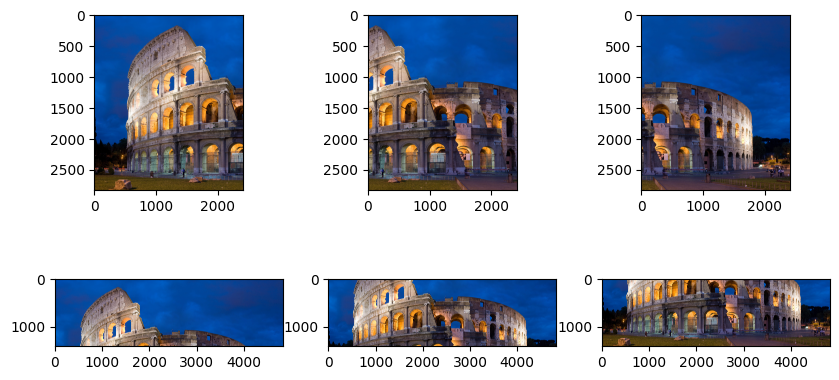

In [101]:
image_pecies_final = [image]

plt.figure(figsize=(10,5))
A, B = image.size
k=0
for i in range(3):
  im = image.crop((A/4*i,0,A/4*i+A/2,B))
  image_pecies_final.append(im)
  plt.subplot(2,3,1+k)
  plt.imshow(im)
  k += 1

for j in range(3):
  im = image.crop((0,B/4*j,A,B/4*j+B/2))
  image_pecies_final.append(im)
  plt.subplot(2,3,1+k)
  plt.imshow(im)
  k += 1

0) a close up of an ancient structure lit up at night
1) a very large clock tower with an illuminated sky in the background
2) clock tower in roman style and night sky
3) the roman colossion is illuminated at night and features a bell and pillars
4) this is an image of a roman colossion
5) an illuminated shot of the colossion at night
6) the statue of person standing near an arch is in front of a building
7) a clock in front of a building and the sun is low behind
8) a couple of people standing next to the colossion


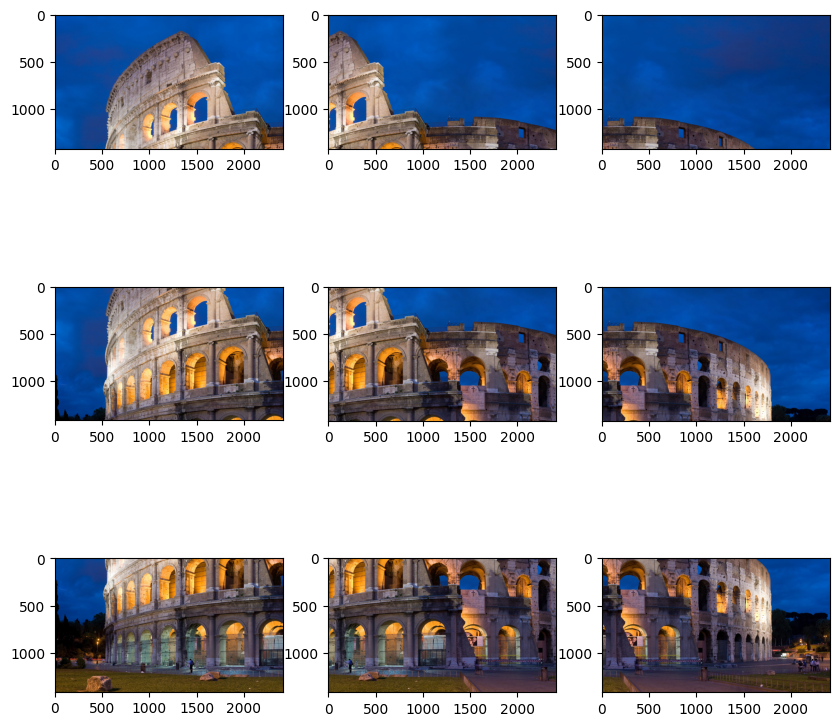

In [102]:
image_pecies = []
captions = []

plt.figure(figsize=(10,10))
A, B = image.size
k=0
for j in range(3):
  for i in range(3):
    im = image.crop((A/4*i,B/4*j,A/4*i+A/2,B/4*j+B/2))
    image_pecies.append(im)
    plt.subplot(3,3,1+k)
    plt.imshow(im)
    input_image = image_preprocess_blip_cap["eval"](im).unsqueeze(0).cuda()
    captions += blip_caption.generate({"image": input_image}, use_nucleus_sampling=True, num_captions=1)
    print(f'{k})',captions[k])
    k += 1


### Encode image and caption

In [103]:
modelCLIP.cuda().eval()

images = [preprocessCLIP(im) for im in image_pecies]

images = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize([desc for desc in captions]).cuda()

with torch.no_grad():
  images_z = modelCLIP.encode_image(images).float()
  texts_z = modelCLIP.encode_text(text_tokens).float()

print(images_z.shape, texts_z.shape)

torch.Size([9, 1024]) torch.Size([9, 1024])


### Target to individualize

In [104]:
TARGET = 'The people in the square'

In [105]:
target_caption = clip.tokenize(TARGET).cuda()

with torch.no_grad():
    target_caption_z = modelCLIP.encode_text(target_caption).float()

### Compute image-target similarity

In [106]:
im_sim = torch.Tensor(0)

for im in images_z:
  similarity = cosine_similarity(im, target_caption_z)
  im_sim = torch.cat((im_sim, similarity),0)

a, b = torch.topk(im_sim, 5, sorted=True)
for i in range(5):
  if a[i]<0.15 :
    b = b[0,i-1]
    break

print(im_sim)
print(a)
print(b)


tensor([0.1411, 0.1541, 0.1475, 0.1426, 0.1512, 0.1417, 0.1635, 0.1709, 0.1571])
tensor([0.1709, 0.1635, 0.1571, 0.1541, 0.1512])
tensor([7, 6, 8, 1, 4])


In [107]:
text_sim = torch.Tensor(0)

for im in texts_z:
  similarity = cosine_similarity(im, target_caption_z)
  text_sim = torch.cat((text_sim, similarity),0)

c, d = torch.topk(text_sim, 5, sorted=True)
print(c)
print(d)
for i in range(5):
  if c[i]<0.8 :
    d = d[0:i]
    break

print(text_sim)
print(c)
print(d)


tensor([0.7718, 0.7696, 0.7121, 0.6801, 0.6562])
tensor([8, 4, 0, 5, 3])
tensor([0.7121, 0.5161, 0.5838, 0.6562, 0.7696, 0.6801, 0.5911, 0.5968, 0.7718])
tensor([0.7718, 0.7696, 0.7121, 0.6801, 0.6562])
tensor([], dtype=torch.int64)


In [108]:
common_idx = list(set(b.tolist()).intersection(d.tolist()))
print(common_idx)
if len(common_idx)==0:
  print('No common idx')
  if len(b)==0:
    common_idx = 0
    print('b==0')
    print(common_idx)
  elif len(d)==0:
    common_idx=b.tolist()
    print('d==0')
    print(common_idx)
  else:
    print('b==0 & d==0')
    common_idx=0
    print(common_idx)


[]
No common idx
d==0
[7, 6, 8, 1, 4]


In [109]:
a = 0
if all(x in common_idx for x in [0, 1, 2]):
  a = 1
elif all(x in common_idx for x in [3, 4, 5]):
  a = 2
elif all(x in common_idx for x in  [6,7,8]):
  a = 3
elif all(x in common_idx for x in [0, 3, 6]):
  a = 4
elif all(x in common_idx for x in [1, 4, 7]):
  a = 5
elif all(x in common_idx for x in [2, 5, 8]):
  a = 6

print(a)


3


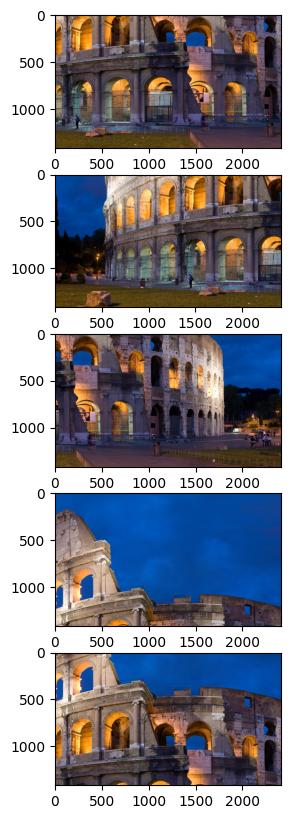

In [110]:
plt.figure(figsize=(10,10))
l = len(common_idx)
k=0
for j in common_idx:
  plt.subplot(l,1,1+k)
  plt.imshow(image_pecies[j])
  k += 1

### Visualize best result

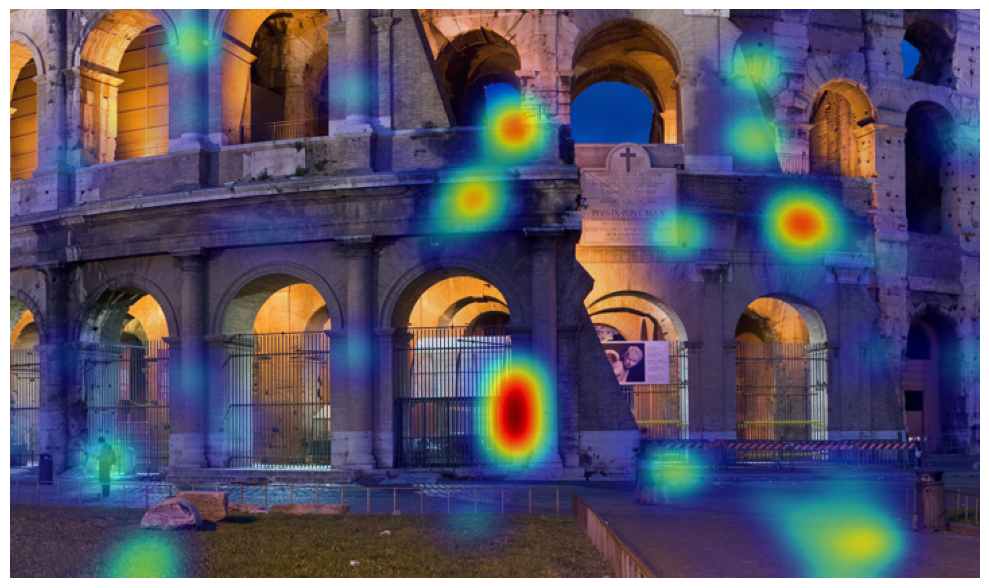

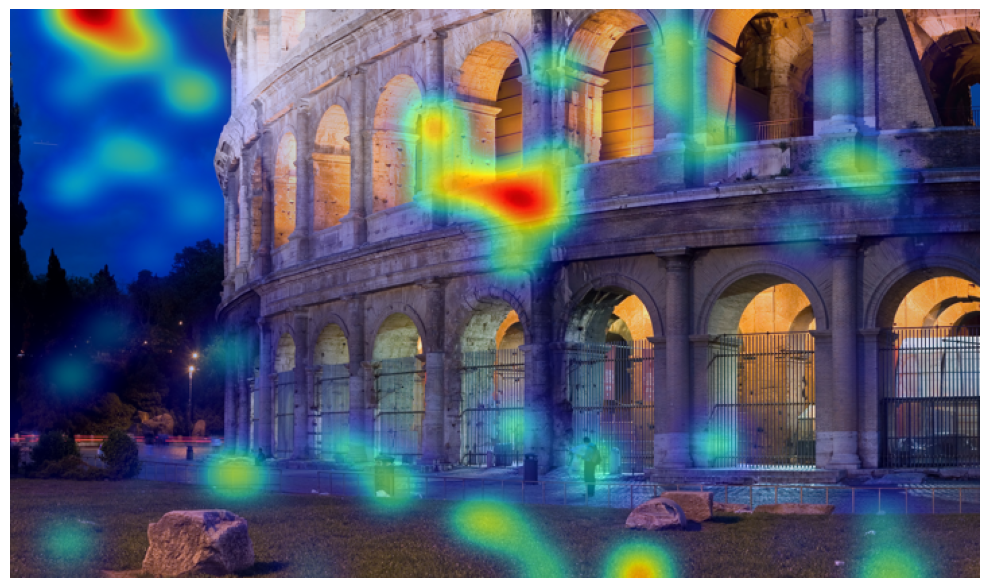

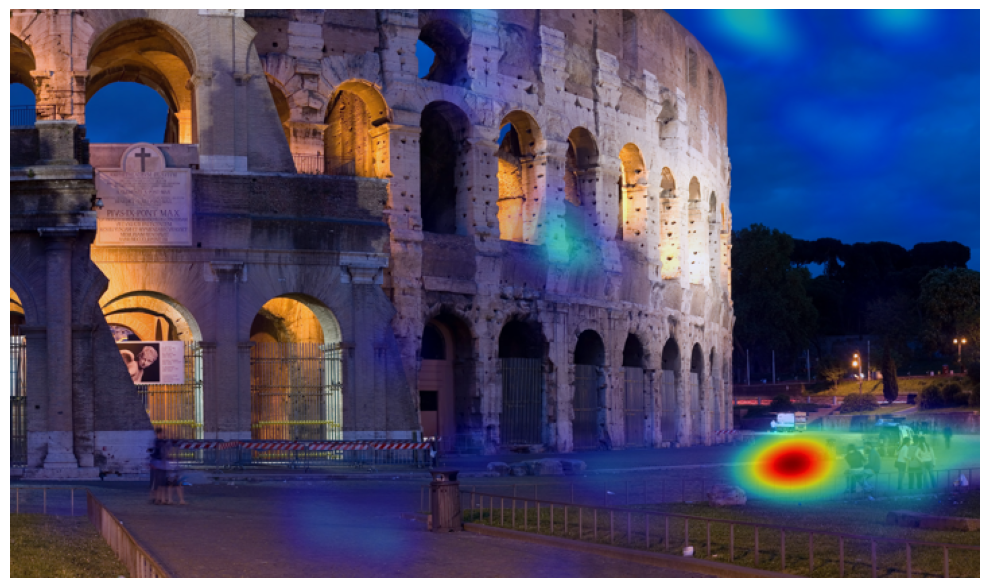

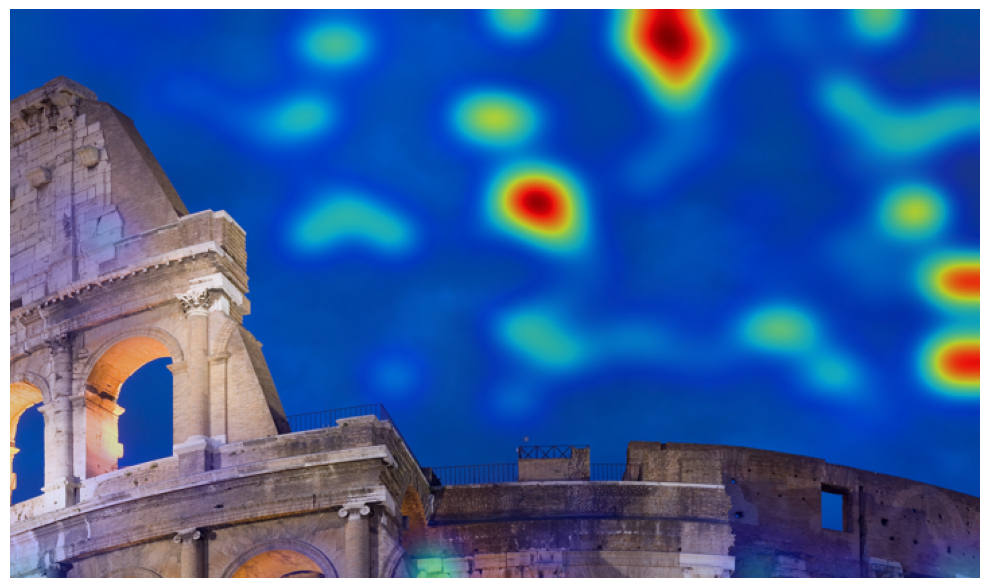

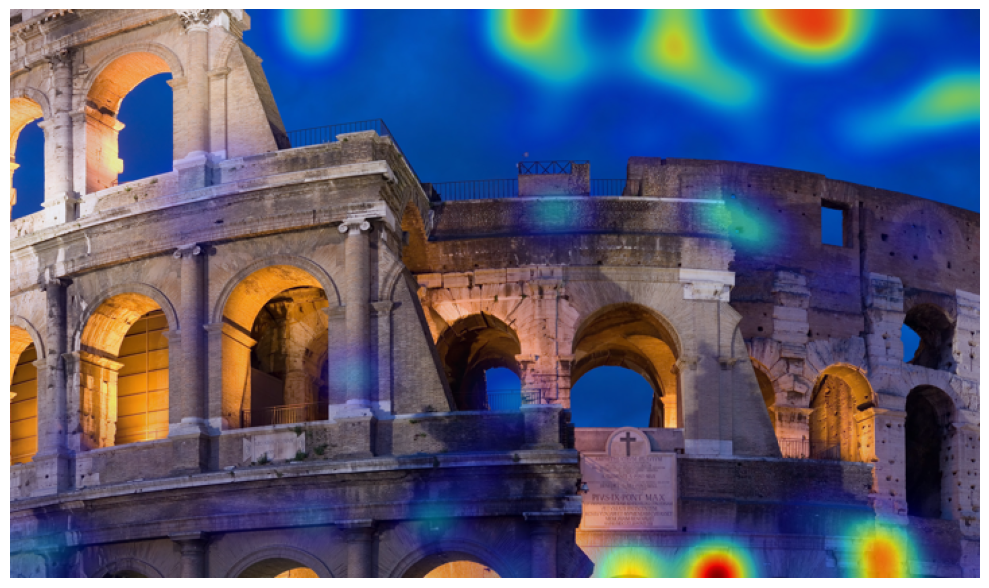

In [111]:
input_text = text_preprocess_im_text_match["eval"](TARGET)

for i in range(len(common_idx)):
  input_image = image_preprocess_im_text_match["eval"](image_pecies[common_idx[i]]).unsqueeze(0).cuda()
  text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')

  # evaluate the gradcam
  gradcam, _ = compute_gradcam(
    blip_im_text_match, input_image, input_text, text_tokens, block_num=7
  )

  # visualise the gradcam
  visualise_gradcam(gradcam, image_pecies[common_idx[i]], text_tokens=text_tokens, average=True)

### Restricted image

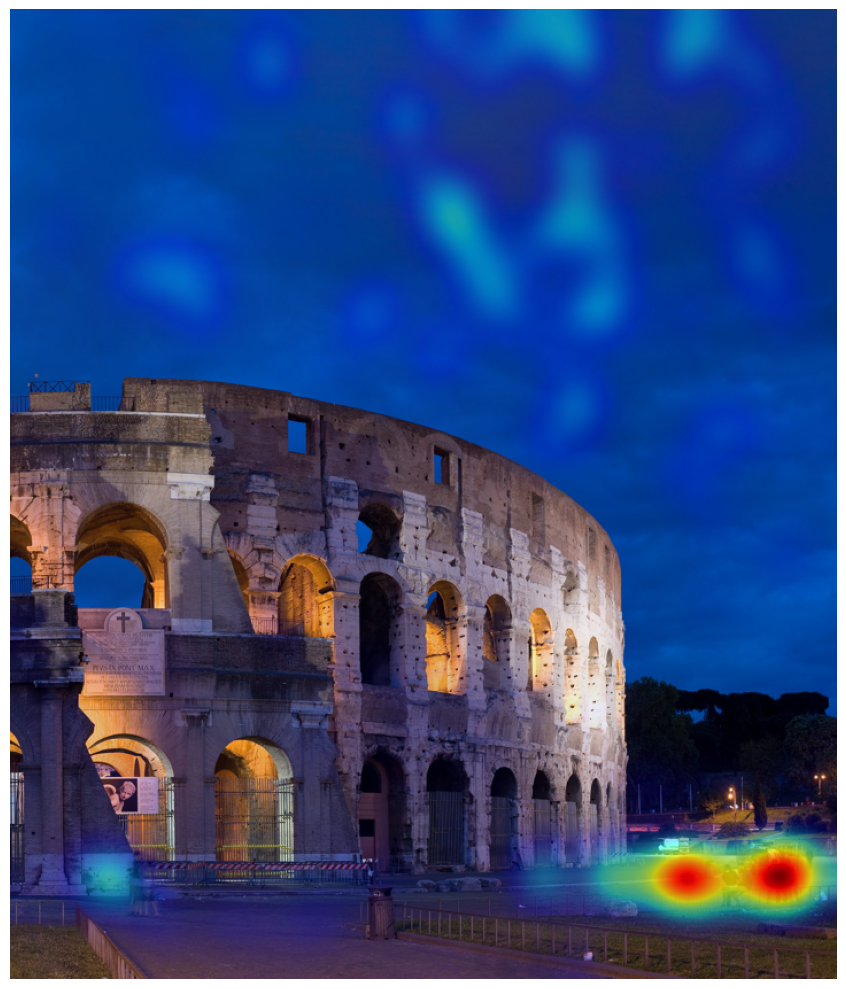

In [112]:
input_image = image_preprocess_im_text_match["eval"](image_pecies_final[a]).unsqueeze(0).cuda()
text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')

input_text = text_preprocess_im_text_match["eval"](TARGET)

# evaluate the gradcam
gradcam, _ = compute_gradcam(
  blip_im_text_match, input_image, input_text, text_tokens, block_num=7
)

# visualise the gradcam
visualise_gradcam(gradcam, image_pecies_final[a], text_tokens=text_tokens, average=True)

### Visualize general result

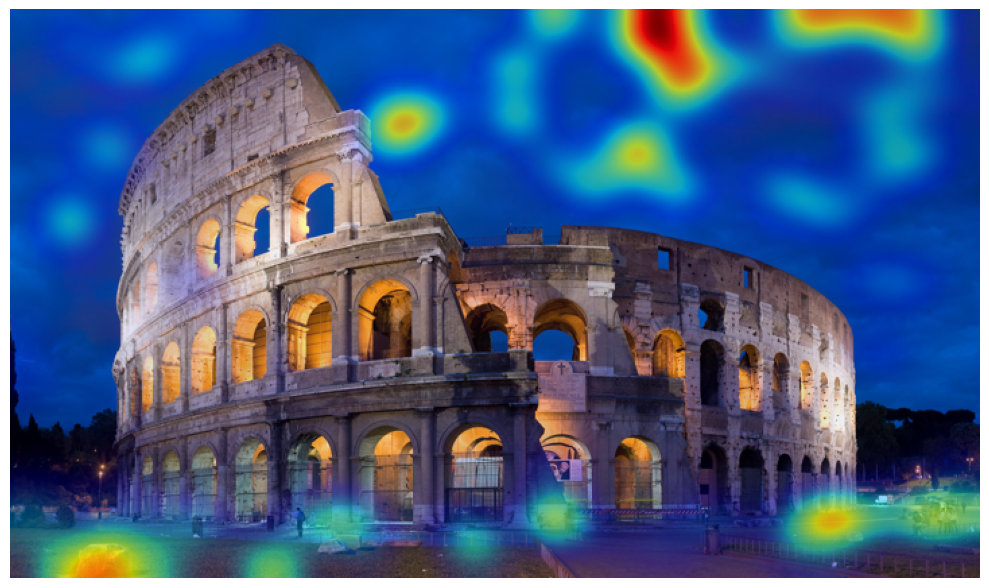

In [113]:
input_image = image_preprocess_im_text_match["eval"](image).unsqueeze(0).cuda()
text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')

input_text = text_preprocess_im_text_match["eval"](TARGET)

# evaluate the gradcam
gradcam, _ = compute_gradcam(
  blip_im_text_match, input_image, input_text, text_tokens, block_num=7
)

# visualise the gradcam
visualise_gradcam(gradcam, image, text_tokens=text_tokens, average=True)